In [125]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from io import BytesIO
from PIL import Image
import imageio
import random
import time
from IPython.display import Image, display
import pandas as pd

# Initialization

In [2]:
def available_digits(arr, row_square, col_square):
    used = set()

    for row in range(3):
        for col in range(3):
            used.add(arr[3 * row_square + row][3 * col_square + col])
    
    available = {i for i in range(1, 10)}.difference(used)

    return available

In [3]:
def fill_empty_spaces(arr, row_square, col_square, available):
    k = len(available)

    for row in range(3):
        for col in range(3):
            if arr[3 * row_square + row][3 * col_square + col] == 0:
                num = random.choice(list(available))
                available.remove(num)
                arr[3 * row_square + row][3 * col_square + col] = num

In [30]:
def read_sudoku_hint(sudoku_hint_path):
    file = open(sudoku_hint_path, "r")
    unmoveable_positions = set()

    arr = np.array(list(map(lambda x: list(x.strip().replace('x', '0')), file.readlines())), dtype = int)

    blank_spaces = 81 - np.count_nonzero(arr)

    for row in range(9):
        for col in range(9):
            if arr[row][col] != 0:
                unmoveable_positions.add((row, col))

    return arr, blank_spaces, unmoveable_positions

In [31]:
def init_solution(sudoku_hint_path):
    arr, _, unmoveable_positions = read_sudoku_hint(sudoku_hint_path)

    for row_square in range(3):
        for col_square in range(3):
            available = available_digits(arr, row_square, col_square)
            fill_empty_spaces(arr, row_square, col_square, available)
            
    return arr, unmoveable_positions

# Auxiliary functions

In [6]:
def used_in_row(arr, row):
    used = set(arr[row, :])

    return used

In [7]:
def used_in_col(arr, col):
    used = set(arr[:, col])

    return used

In [8]:
def count_penalty(arr):
    penalty = 0

    for row in range(9):
        used = used_in_row(arr, row)
    
        penalty += 9 - len(used)

    for col in range(9):
        used = used_in_col(arr, col)
        
        penalty += 9 - len(used)
    
    return penalty

In [9]:
def validate_solution(arr):
    return count_penalty(arr) == 0

In [35]:
def modify_solution(arr, unmoveable_positions):
    square_row, square_col = np.random.choice(list(range(3)), 2)
    row1, col1, row2, col2 = np.random.choice(list(range(3)), 4)

    while (3 * square_row + row1, 3 * square_col + col1) in unmoveable_positions or (3 * square_row + row2, 3 * square_col + col2) in unmoveable_positions:
            square_row, square_col = np.random.choice(list(range(3)), 2)
            row1, col1, row2, col2 = np.random.choice(list(range(3)), 4)

    curr_penalty = count_penalty(arr)

    arr[3 * square_row + row1][3 * square_col + col1], arr[3 * square_row + row2][3 * square_col + col2] = arr[3 * square_row + row2][3 * square_col + col2], arr[3 * square_row + row1][3 * square_col + col1]

    new_penalty = count_penalty(arr)

    return new_penalty - curr_penalty, square_row, square_col, row1, col1, row2, col2


In [11]:
def revert_modify(arr, square_row, square_col, row1, col1, row2, col2):
    arr[3 * square_row + row1][3 * square_col + col1], arr[3 * square_row + row2][3 * square_col + col2] = arr[3 * square_row + row2][3 * square_col + col2], arr[3 * square_row + row1][3 * square_col + col1]

In [84]:
def accept_updated_solution(T, dE):
    if dE < 0:
        return True
    
    else:
        p = np.exp(-dE / T)
        r = np.random.uniform(low = 0, high = 1)

        return r < p

# Visualization

In [13]:
def vis_sudoku(arr):
    plt.imshow(arr, cmap='plasma', interpolation='nearest')
    plt.colorbar()

In [14]:
def save_frame_to_gif(arr):
    vis_sudoku(arr)
    plt.savefig("./vis/img.png",
        transparent = False,
        facecolor = 'white'
    )

    plt.close()

In [15]:
def update_vis_gif(arr, frames):
    save_frame_to_gif(arr)

    image = imageio.v2.imread("./vis/img.png")
    frames.append(image)

In [19]:
def display_gif(gif_path = './vis/sudoku.gif'):
    display(Image(filename = gif_path))

In [20]:
def draw_timeline(logs):
    iterations = list(range(len(logs)))

    plt.plot(iterations, logs)

    plt.show()

In [23]:
def draw_iterations_vs_blanks(benchmark_logs):
    plt.scatter(benchmark_logs[:, 2], benchmark_logs[:, 0])

    plt.show()

# Simulation algorithm

In [117]:
def attempt(arr, unmoveable_positions, t_func, T, log_step, logs, max_no_iterations):
    penalty = count_penalty(arr)

    for i in range(max_no_iterations):
        dE, square_row, square_col, row1, col1, row2, col2 = modify_solution(arr, unmoveable_positions)

        if accept_updated_solution(T, dE):
            penalty += dE
        else:
            revert_modify(arr, square_row, square_col, row1, col1, row2, col2)

        if i % log_step == 0:
            logs.append(penalty)

        i += 1
        T = t_func(T)

        if penalty == 0:
            break

    return penalty, arr, logs, i

In [118]:
def simulation(sudoku_hint_path, t_func = lambda x: x * 0.999, T = 1, log_step = 10 ** 3, max_iter_no_restart = 64000, max_iter_no_attempt = 8000):
    arr, unmoveable_positions = init_solution(sudoku_hint_path)
    penalty = count_penalty(arr)
    logs = []
    i = 0
    j = 0

    while penalty != 0: 
        if i > max_iter_no_restart:
            i = 0
            arr, unmoveable_positions = init_solution(sudoku_hint_path)
        
        penalty, arr, _, k = attempt(arr, unmoveable_positions, t_func, T, log_step, logs, max_iter_no_attempt)
        i += k
        j += k
    
    return True, arr, logs, j

# Simulation with visualization

In [136]:
def vis_attempt(arr, unmoveable_positions, t_func, T, vis_step, frames, max_no_iterations):
    penalty = count_penalty(arr)

    for i in range(max_no_iterations):
        dE, square_row, square_col, row1, col1, row2, col2 = modify_solution(arr, unmoveable_positions)

        if accept_updated_solution(T, dE):
            penalty += dE
        else:
            revert_modify(arr, square_row, square_col, row1, col1, row2, col2)

        if i % vis_step == 0:
            update_vis_gif(arr, frames)

        i += 1
        T = t_func(T)

        if penalty == 0:
            break

    return penalty, arr, i

In [147]:
def vis_simulation(sudoku_hint_path, t_func = lambda x: x * 0.999, T = 1, vis_step = 10 ** 2, max_iter_no_restart = 64000, max_iter_no_attempt = 8000):

    arr, unmoveable_positions = init_solution(sudoku_hint_path)
    penalty = count_penalty(arr)
    frames = []
    i = 0
    j = 0

    while penalty != 0: 
        if i > max_iter_no_restart:
            i = 0
            arr, unmoveable_positions = init_solution(sudoku_hint_path)
        
        penalty, arr, k = vis_attempt(arr, unmoveable_positions, t_func, T, vis_step, frames, max_iter_no_attempt)
        i += k
        j += k
    
    update_vis_gif(arr, frames)
    imageio.mimsave('./vis/sudoku.gif', ims = frames, fps = 10, loop = 0)

    return True, arr, j

# Example

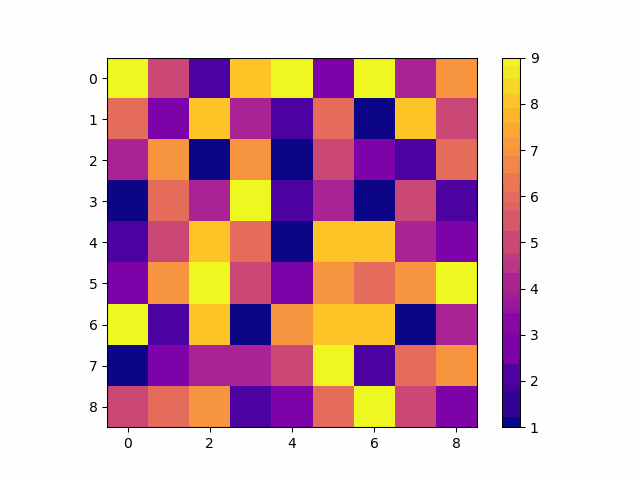

In [148]:
vis_simulation("./sudoku/3.txt")
display_gif()

# Benchmark

In [120]:
def test_validity():
    benchmark_logs = []

    for i in range(1, 51):
        sudoku_hint_path = "sudoku/{i}.txt".format(i = i)

        hint, blank_spaces, _ = read_sudoku_hint(sudoku_hint_path)

        print("Test {i}".format(i = i))
        print("Hint: ")
        print(hint)
        print("\tBlank spaces: {blank_spaces}".format(blank_spaces = blank_spaces))

        time1 = time.time()

        solved, solution, _, iterations = simulation(sudoku_hint_path)

        time2 = time.time()

        print("Solution: ")
        print(solution)
        print("\tPASSED :)" if solved else "\tFAILED :(")
        print("\tTime: {time_diff}".format(time_diff = time2 - time1))
        print("\tIterations: {iterations}".format(iterations = iterations))
        benchmark_logs.append([iterations, time2 - time1, blank_spaces])
    
    return np.array(benchmark_logs)

In [121]:
benchmark_logs = test_validity()

Test 1
Hint: 
[[0 0 3 0 2 0 6 0 0]
 [9 0 0 3 0 5 0 0 1]
 [0 0 1 8 0 6 4 0 0]
 [0 0 8 1 0 2 9 0 0]
 [7 0 0 0 0 0 0 0 8]
 [0 0 6 7 0 8 2 0 0]
 [0 0 2 6 0 9 5 0 0]
 [8 0 0 2 0 3 0 0 9]
 [0 0 5 0 1 0 3 0 0]]
	Blank spaces: 49
Solution: 
[[4 8 3 9 2 1 6 5 7]
 [9 6 7 3 4 5 8 2 1]
 [2 5 1 8 7 6 4 9 3]
 [5 4 8 1 3 2 9 7 6]
 [7 2 9 5 6 4 1 3 8]
 [1 3 6 7 9 8 2 4 5]
 [3 7 2 6 8 9 5 1 4]
 [8 1 4 2 5 3 7 6 9]
 [6 9 5 4 1 7 3 8 2]]
	PASSED :)
	Time: 3.540348768234253
	Iterations: 9647
Test 2
Hint: 
[[2 0 0 0 8 0 3 0 0]
 [0 6 0 0 7 0 0 8 4]
 [0 3 0 5 0 0 2 0 9]
 [0 0 0 1 0 5 4 0 8]
 [0 0 0 0 0 0 0 0 0]
 [4 0 2 7 0 6 0 0 0]
 [3 0 1 0 0 7 0 4 0]
 [7 2 0 0 4 0 0 6 0]
 [0 0 4 0 1 0 0 0 3]]
	Blank spaces: 51
Solution: 
[[2 4 5 9 8 1 3 7 6]
 [1 6 9 2 7 3 5 8 4]
 [8 3 7 5 6 4 2 1 9]
 [9 7 6 1 2 5 4 3 8]
 [5 1 3 4 9 8 6 2 7]
 [4 8 2 7 3 6 9 5 1]
 [3 9 1 6 5 7 8 4 2]
 [7 2 8 3 4 9 1 6 5]
 [6 5 4 8 1 2 7 9 3]]
	PASSED :)
	Time: 6.3245484828948975
	Iterations: 21382
Test 3
Hint: 
[[0 0 0 0 0 0 9 0 7]
 [0 0 0 4

In [131]:
df_iterations = pd.DataFrame(benchmark_logs[:,0])
df_iterations.describe()

,0
count,5.000000e+01
mean,2.518109e+05
std,5.110713e+05
min,1.091000e+03
25%,1.014675e+04
50%,5.387050e+04
75%,2.411825e+05
max,2.935010e+06


In [133]:
df_time = pd.DataFrame(benchmark_logs[:, 1])
df_time.describe()

,0
count,50.000000
mean,64.220830
std,122.207229
min,0.484273
25%,3.430189
50%,17.114411
75%,64.143543
max,680.415276


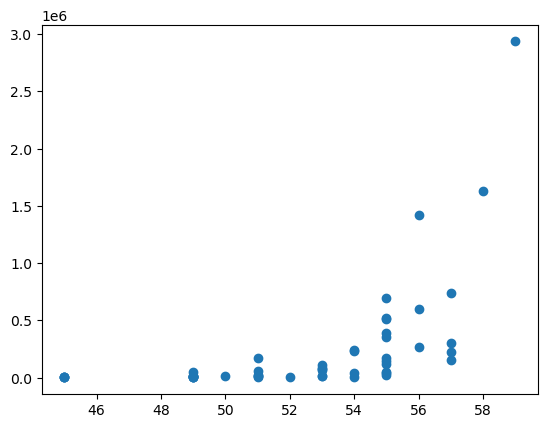

In [134]:
draw_iterations_vs_blanks(benchmark_logs)

# Summary

Ponieważ w każdym kwadracie ostatecznie muszą znaleźć się unikalne cyfry od 1 do 9, w momencie inicjalizacji rozwiązania, algorytm wypełnia sudoku w taki sposób, by każdy kwadrat $3\times3$ wypełniony był prawidłowym zbiorem cyfr. Na etapie modyfikacji rozwiązania, algorytm wybiera kwadrat, w którym dwie losowo wybrane cyfry zostaną zamienione miejscami, a nowe rozwiązanie zostaje porównane z obecnym. Przyjęta funkcja kosztu to suma powtórzeń cyfr występujących w wierszach i kolumnach kwadratu $9\times9$. 

Ponieważ w przedstawionym problemie łatwo jest wpaść w niewłaściwe minimum lokalne (i nigdy już z niego nie wyjść), a ostatecznie zależy nam na rozwiązaniu sudoku (więc rozwiązanie musi być dokładne, a nie przybliżone), w trakcie działania algorytmu, po określonej liczbie kroków temperatura zostaje resetowana do stanu początkowego. Jeśli nie jest to wystarczające do rozwiązania danego sudoku, po określonej liczbie kroków symulacji, algorytm ponownie inicjalizuje rozwiązanie początkowe i zaczyna swoje działanie od początku. Jest to zabieg konieczny, ponieważ funkcja opisująca "energię" sudoku posiada wiele minimów lokalnych, z których przy standardowym podejściu możemy się nie wydostać.

Liczba iteracji oraz czas potrzebne do rozwiązania poszczególnych układów sudoku mają bardzo duży rozstęp. Jest to spodowane niewątpliwie różnym poziomem trudności poszczególnych układów, jednak ze względu na losowość podczas inicjalizacji rozwiązania oraz modyfikacji rozwiązania, czasem znacznie łatwiejsza łamigłówka może wymagać więcej czasu i iteracji algorytmu. Algorytm jest niedeterministyczny, kolejne wywołanie funkcji $test_validity()$ zwraca inne wyniki i wymaga innej liczby iteracji i czasu.

W użytych w moim rozwiązaniu układach sudoku, ilość pustych miejsc nie różni się znacząco (wartość średnia wynosi około 55 pustych pozycji), ciężko dopatrywać się znaczącej zależności liczby koniecznych iteracji algorytmu w zależności od pustych miejsc, jednak można dostrzeć pewien wzrost liczby koniecznych iteracji wraz ze wzrostem ilości pustych miejsc w sudoku.

Algorytm oparty na powyższych założeniach i odpowiednim dobraniu wartości początkowej $T_0$, funkcji akceptacji oraz funkcji spadku temperatury jest w stanie rozwiązać wszystkie 50 przypadków testowych.